# Clustering practical course

Clustering is an unsupervised machine learning technique (= labels not known) used to group data points together based on similarities.
___

In this practical, we will run K-means and hierachical clustering on the TCGA-PANCAN-HiSeq-801x20531 dataset downloadable from the UCI machine learning repository. 
This dataset is part of the RNA-Seq (HISeq) PANCAN dataset. It is a random extraction of gene expressions of patients having different types of tumor: BRCA (breast invasive carcinoma), KIRC (kidney renal clear cell carcinoma), COAD (colon adenocarcinoma), LUAD (lung adenocarcinoma) and PRAD (prostate adenocaarcinoma).

In total, we have 801 patients (samples) and 20 531 genes (attributes/features).

## Package import

In [7]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Data download and extraction

In [8]:
# If you get the error "SSL: CERTIFICATE VERIFY FAILED": uncomment the next two lines
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [4]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = pd.read_csv(datafile, index_col=0)
labels = pd.read_csv(labels_file, index_col=0)

## Data preprocessing

Visualize the 10 first rows of both data and labels

In [6]:
data.head(10)

NameError: name 'data' is not defined

In [5]:
isNull = data.isnull().sum()
print(isNull)

NameError: name 'data' is not defined

In [4]:
# Check for missing values in the data
missing_values = data.isnull().sum().sum()
print(f"Total missing values in the data: {missing_values}")

NameError: name 'data' is not defined

Are there any missing values (in data)? What type are the variables?

### No, there are no missing values in data. The gene expression data is a type of high-dimensional data. In this case, the data has 20,531 features, which correspond to the expression levels of 20,531 genes. There are multiple genes that have no expression This is a common scenario in bioinformatics and other fields that deal with high-dimensional data.


Use the describe method on the first 10 genes and explain what you obtain. 

In [16]:
data.head(10).describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,10.0,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.0,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.0,2.762335,3.073020,6.696013,9.891894,0.0,7.147663,0.344872,0.0,0.406760,...,5.559031,8.446362,10.011278,6.228524,9.735063,11.816471,9.739990,9.572732,5.029133,0.0
std,0.0,1.145260,1.143444,0.546071,0.354992,0.0,0.654318,0.261769,0.0,1.286289,...,0.653704,0.619484,0.411320,1.908275,0.655652,1.175116,0.455762,0.438197,2.214473,0.0
min,0.0,0.592732,1.588421,5.478487,9.464466,0.0,5.952103,0.000000,0.0,0.000000,...,4.593372,7.323865,9.599230,1.877744,8.381612,9.045255,9.217749,8.921326,1.683023,0.0
25%,0.0,2.176842,2.006041,6.553021,9.657090,0.0,6.770178,0.088077,0.0,0.000000,...,5.110731,8.147906,9.727870,5.575244,9.651579,11.433760,9.346324,9.282628,3.658789,0.0
50%,0.0,3.161353,3.043537,6.639656,9.748478,0.0,7.073652,0.397932,0.0,0.000000,...,5.512245,8.439840,9.846046,6.194085,9.831456,11.962787,9.679650,9.472745,5.198565,0.0
75%,0.0,3.609810,4.140878,6.873718,10.114821,0.0,7.741438,0.512050,0.0,0.000000,...,6.014046,8.772922,10.229702,7.210313,9.920585,12.627513,9.937890,9.798446,6.252401,0.0
max,0.0,3.992125,4.507649,7.586157,10.488252,0.0,7.947216,0.724214,0.0,4.067604,...,6.721974,9.597533,10.908640,8.942805,10.952880,13.256060,10.517059,10.390255,8.330912,0.0


Based on the above answer, do you think the data should be scaled? If yes, do it and compare the obtained data to the original data (only first 10 genes). 

In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Convert scaled data back to DataFrame for comparison
scaled_data_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

# Compare the original and scaled data (only the first 10 rows)
comparison = pd.concat([data.head(10), scaled_data_df.head(10)], axis=1, keys=['Original', 'Scaled'])
comparison

Original                                                            \
           gene_0    gene_1    gene_2    gene_3     gene_4 gene_5    gene_6   
sample_0      0.0  2.017209  3.265527  5.478487  10.431999    0.0  7.175175   
sample_1      0.0  0.592732  1.588421  7.586157   9.623011    0.0  6.816049   
sample_2      0.0  3.511759  4.327199  6.881787   9.870730    0.0  6.972130   
sample_3      0.0  3.663618  4.507649  6.659068  10.196184    0.0  7.843375   
sample_4      0.0  2.655741  2.821547  6.539454   9.738265    0.0  6.566967   
sample_5      0.0  3.467853  3.581918  6.620243   9.706829    0.0  7.758510   
sample_6      0.0  1.224966  1.691177  6.572007   9.640511    0.0  6.754888   
sample_7      0.0  2.854853  1.750478  7.226720   9.758691    0.0  5.952103   
sample_8      0.0  3.992125  2.772730  6.546692  10.488252    0.0  7.690222   
sample_9      0.0  3.642494  4.423558  6.849511   9.464466    0.0  7.947216   

                                     ...     Scaled                        \
            gene_7 gene_8    gene_9  ... gene_20521 gene_20522 gene_20523   
sample_0  0.591871    0.0  0.000000  ...  -1.300200  -0.921755  -0.877838   
sample_1  0.000000    0.0  0.000000  ...  -1.747076  -2.392213  -0.831893   
sample_2  0.452595    0.0  0.000000  ...  -1.034088  -1.059669   2.248803   
sample_3  0.434882    0.0  0.000000  ...   0.241299   0.044905   0.224956   
sample_4  0.360982    0.0  0.000000  ...   0.133335   0.208252   0.837739   
sample_5  0.000000    0.0  0.000000  ...  -0.227790  -0.270908  -0.337465   
sample_6  0.531868    0.0  0.000000  ...  -1.059973  -1.390053  -1.008562   
sample_7  0.000000    0.0  0.000000  ...  -0.802672  -0.810881  -1.205733   
sample_8  0.352307    0.0  4.067604  ...   1.106536   1.379633  -0.771681   
sample_9  0.724214    0.0  0.000000  ...   0.165535  -0.088059   0.535150   

                                                                            \
         gene_20524 gene_20525 gene_20526 gene_20527 gene_20528 gene_20529   
sample_0   0.996247  -1.166072   0.389441  -0.869566  -1.187938  -0.116483   
sample_1   0.591649  -2.549598   1.391628   0.623551  -0.342277  -1.656889   
sample_2   0.232601   0.317880  -4.025621  -0.632381   0.886860  -1.855264   
sample_3   1.719725  -0.263847  -0.521747  -0.793609   0.166174  -1.078941   
sample_4   0.979924   0.196645   0.268992  -1.615841  -0.229878  -0.201588   
sample_5   0.524276   0.138716  -0.276487  -1.570339   0.436110  -0.083493   
sample_6  -1.247242   0.113773   2.259612  -0.845879  -0.614923   1.352303   
sample_7   0.166536   0.472955   1.385397  -0.288756  -0.663454   0.493743   
sample_8   1.295775   2.269439   1.129470   0.404482   1.418868   1.109806   
sample_9   0.539154   0.340341  -0.892501  -1.569130  -0.188869  -0.371051   

                     
         gene_20530  
sample_0  -0.261901  
sample_1  -0.261901  
sample_2  -0.261901  
sample_3  -0.261901  
sample_4  -0.261901  
sample_5  -0.261901  
sample_6  -0.261901  
sample_7  -0.261901  
sample_8  -0.261901  
sample_9  -0.261901  

[10 rows x 41062 columns]

What is the gene expression value of 'gene_3' for 'sample_7' ? 

In [13]:
gene_expression_value = data.loc["sample_7", "gene_3"]
gene_expression_value



np.float64(7.22672044861)

How many classes are there? Plot the distribution of the classes. Is the data balanced or imbalanced? 

In [14]:
num_classes = labels['Class'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 5


Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


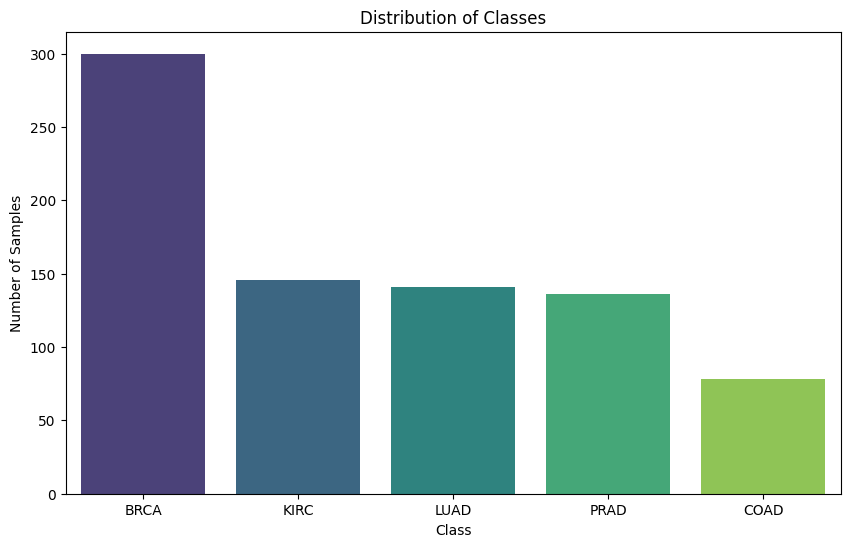

The data is imbalanced.


In [20]:
# Check if the data is balanced
class_distribution = labels['Class'].value_counts()
print(class_distribution)

# Plot the distribution of the classes
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis', hue=class_distribution.index, legend=False)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# Determine if the data is balanced
if class_distribution.max() / class_distribution.min() > 1.5:
    print("The data is imbalanced.")
else:
    print("The data is balanced.")

Encode your labels into a numerical variable.

In [21]:
# Encode the labels into a numerical variable
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels['Class'])
encoded_labels

array([4, 3, 4, 4, 0, 4, 2, 4, 0, 4, 0, 2, 4, 0, 0, 0, 3, 2, 2, 4, 0, 2,
       3, 0, 2, 3, 1, 0, 0, 0, 0, 0, 2, 0, 4, 0, 2, 3, 0, 0, 2, 4, 4, 2,
       2, 0, 4, 1, 0, 3, 0, 3, 0, 4, 1, 0, 0, 1, 2, 0, 3, 2, 0, 3, 4, 1,
       0, 4, 2, 0, 2, 0, 0, 3, 0, 3, 0, 2, 4, 1, 0, 4, 0, 0, 4, 4, 0, 0,
       2, 0, 4, 4, 0, 0, 0, 4, 1, 0, 4, 0, 0, 2, 0, 2, 3, 2, 3, 1, 3, 3,
       4, 0, 3, 4, 0, 2, 2, 2, 0, 0, 3, 2, 3, 0, 4, 4, 4, 0, 2, 3, 1, 0,
       1, 0, 0, 2, 3, 0, 2, 1, 0, 4, 0, 2, 3, 1, 4, 0, 3, 3, 3, 3, 0, 0,
       3, 0, 0, 4, 4, 3, 4, 3, 2, 0, 4, 3, 1, 2, 3, 0, 2, 3, 0, 3, 0, 0,
       0, 4, 0, 2, 1, 2, 0, 4, 4, 4, 3, 3, 0, 3, 3, 2, 3, 4, 3, 0, 0, 0,
       3, 3, 0, 2, 2, 2, 2, 4, 0, 4, 0, 3, 3, 0, 4, 0, 4, 0, 0, 0, 3, 0,
       2, 3, 2, 2, 3, 0, 2, 4, 0, 3, 3, 4, 1, 0, 2, 4, 2, 1, 0, 2, 2, 3,
       4, 4, 3, 3, 2, 0, 0, 1, 0, 4, 1, 0, 4, 2, 4, 4, 4, 0, 1, 1, 3, 1,
       1, 4, 3, 0, 0, 2, 2, 0, 1, 4, 2, 4, 0, 0, 2, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 3, 4, 0,

Check if your data and labels are numpy arrays. If that is not the case, transform your data and labels into numpy arrays. 

In [24]:
isnumpyarray = isinstance(encoded_labels, np.ndarray)
print(isnumpyarray)

True


## Clustering algorithm 1: K-means

Apply the K-means algorithm with 2 centers. Look at the default parameters the method takes. Set the random_state to 42 and make sure the algorithm doesn't run more than 500 iterations.

In [25]:
# Apply the K-means algorithm with 2 centers
kmeans = KMeans(n_clusters=2, random_state=42, max_iter=500)
kmeans.fit(data)

# Get the cluster labels
cluster_labels = kmeans.labels_
cluster_labels

array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

What does the random_state parameter do? 

## Ensures the reproducibility of the results, sets the same randoms parameters to the same values, and ensures that the results are consistent across different runs of the algorithm.

How many samples are in each cluster? 

In [26]:
# Count the number of samples in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(cluster_counts)

{np.int32(0): np.int64(665), np.int32(1): np.int64(136)}


In order to optimize our clusters, we want to apply the silhouette method to obtain the optimal number of centers. 
Apply silhouette on a range from 2 to 10 centers, display the average silhouette score for each and display the silhouette plot for each center. 
<br> For some help, look at the silhouette documentation in scikit learn: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

<br> 

Please note that the code below is NOT complete. Fill in the missing parts (they are indicated by ### TO COMPLETE) 

In [ ]:
range_n_clusters =   ### TO COMPLETE

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples


for n_clusters in range_n_clusters:
    # Create a plot
    fig, ax  = plt.subplots(1,1, figsize=(8,6))

    # This plot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed 42 for reproducibility.
    clusterer =  ### TO COMPLETE (with random state = 42)
    cluster_labels = ### TO COMPLETE
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = ### TO COMPLETE 
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = ### TO COMPLETE
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.title(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

What is, in your opinion, the best number of centers to choose. 

Apply K-means again with the optimal number of centers.

How many samples are in each cluster?

Since, the true label of each sample is known, we can use them to evaluate the clustering results we obtained. 
<br>
1- Give the contingency matrix of the clustering.

2- Discuss the obtained matrix

With clustering being an unsupervised learning method, classification evaluation metrics (accuracy, precision, etc) are not appropriate. Instead, we can use clustering evaluation metrics (rand index, adjusted rand index, homogeneity, completeness and V-measure). 
<br>
Check the scikit learn documentation to understand each score: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
<br>
3- Compute all metrics defined above. 

4- Discuss the obtained scores. 

## Clustering algorithm 2: Hierarchical clustering

Apply the hierarchical clustering algorithm with 2 centers. Look at the default parameters and make sure the algorithm is based on the single linkage method. 

How many samples are in each cluster?

Apply the hierarchical clustering algorithm again. This time,  change the linkage method to complete linkage.

How many samples are in each cluster?

Apply the hierarchical clustering algorithm once again. This time, change the linkage method to ward linkage.

How many samples are in each cluster?

Compare the three results. Is the type of linkage method used important? Which one gave you the best result? For the rest of this section, use the best linkage method.

In order to optimize our clusters, we want to apply the silhouette method to obtain the optimal number of centers. 
Apply silhouette on a range from 2 to 10 centers, display the average silhouette score for each and display the silhouette plot for each center. 
<br> For some help, look at the silhouette documentation in scikit learn: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

<br> 

Please note that the code below is NOT complete. Fill in the missing parts (they are indicated by ### TO COMPLETE) 

In [ ]:
range_n_clusters =   ### TO COMPLETE

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples


for n_clusters in range_n_clusters:
    # Create a plot
    fig, ax  = plt.subplots(1,1, figsize=(8,6))

    # This plot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value.
    clusterer =  ### TO COMPLETE
    cluster_labels = ### TO COMPLETE
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = ### TO COMPLETE 
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = ### TO COMPLETE
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.title(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

What is, in your opinion, the best number of centers to choose. 

Apply hierarchical clustering again with the optimal number of centers.

How many samples are in each cluster?

Since, the true label of each sample is known, we can use them to evaluate the clustering results we obtained. 
<br>
1- Give the contingency matrix of the clustering.

2- Discuss the obtained matrix.

With clustering being an unsupervised learning method, classification evaluation metrics (accuracy, precision, etc) are not appropriate. Instead, we can use clustering evaluation metrics (rand index, adjusted rand index, homogeneity, completeness and V-measure). 
<br>
Check the scikit learn documentation to understand each score: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
<br>
3- Compute all metrics defined above. 

4- Discuss the obtained scores.

OPTIONAL: plot the dendrogram

## Conclusion

In your opinion, which method gave the better results for this dataset?

Usually, when we apply different clustering methods, it's because we do not know the labels. In such situation, we compare the different clustering models we obtained with each method to each other to see if they are corroborating. 
<br>
Calculate the metrics defined above but this time between the Kmeans and HClust models (do not rerun the models, just compare the predicted clusters you obtained with each method before).  

Discuss the obtained scores. 

At the beginning of the practical, we saw that there were 5 classes. After completing all the work, applying silhouette and finding the optimal number of clusters, were you expecting the results you obtained? Can you find any biological explanation for the result? 